# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [1]:
# Import libraries
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [2]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype)
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype)
I = torch.eye(2, dtype=exp_dtype)

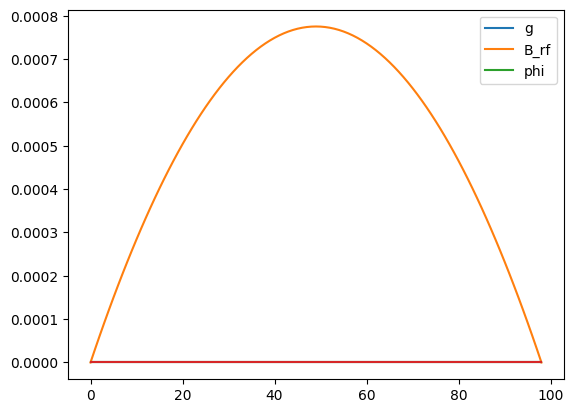

In [3]:
# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 1e-8
t_units = np.arange(Ti, Tf-dt, dt)
M = int((Tf - Ti) // dt)
t = np.arange(M) 


# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 1 # Tesla
kB = 1.38e-23 # J/K
Te = 0.1 # Electron temp
f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf
w = 2 * muB * B0 / hbar

# Define control parameters
g = np.zeros(M)
B_rf = np.zeros(M) 
phi = np.zeros(M)
J = np.zeros(M)

# Interpolate to give it some shape
interp_step = M // 2
scale = 1000

def interpolate_parameter(param, t, interp_step, scale):
    param[::interp_step] = np.random.rand(M // interp_step + 1) / scale # T
    param[0] = 0
    param[-1] = 0
    param = CubicSpline(t[::interp_step], param[::interp_step])
    return param(t)

B_rf = interpolate_parameter(B_rf, t, interp_step, scale)
# g = interpolate_parameter(g, t, interp_step, scale)
# phi = interpolate_parameter(phi, t, interp_step, scale)
# J = interpolate_parameter(J, t, interp_step, scale)

plt.plot(g, label="g")
plt.plot(B_rf, label="B_rf")
plt.plot(phi, label="phi")
plt.plot(J)
plt.legend(loc="best")
plt.show()

# Convert to optimization variables with torch properties
g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)
J = Variable(torch.tensor(J, dtype=exp_dtype), requires_grad=True)


In [4]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)

# Define Lindblad operators
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up
T1 = 1e-3
T2 = 1e-6

L1 = np.sqrt(P_up / (2 * T1)) * sigma_plus
L2 = np.sqrt(P_down / (2 * T1)) * sigma_minus
L3 = sigma_z / (2 * np.sqrt(T2))

L = [L1, L2, L3]

# Construct total matrix
L_total = torch.zeros(4, 4, dtype=exp_dtype)
for i in range(len(L)):
    L_total += 2 * kron(L[i], torch.conj(L[i])) - kron(torch.matmul(hermitian_conj(L[i]), L[i]), I) - kron(I, torch.matmul(L[i].transpose(0,1), torch.conj(L[i])))


In [5]:
# Construct superoperator
def L_F(g, B_rf, phi, J, L, dispersive=False):
    Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
    for i in range(M):
        H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]).item() * sigma_x + torch.sin(phi[i]).item() * sigma_y)
        Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
    exp_Gamma = torch.matrix_exp(Gamma * dt)
    product = torch.eye(4, dtype=exp_dtype)
    for matrix in exp_Gamma: # Use torch.einsum? 
        product = torch.mm(product, matrix)
    return product

print(L_F(g, B_rf, phi, J, L))

# Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
theta = np.pi/2
UF = RX(theta)
HF = (theta/2) * sigma_x
L_desired = torch.matrix_exp( -1j *(kron(HF, I) - kron(I, HF.transpose(0,1))))

# Check out density matrices
rho0 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            L_F(g, B_rf, phi, J, L), rho0.view(-1,)
        )

print(L_desired)
print(rho_desired.view(2,2))
print(rho.view(2,2))



tensor([[ 1.0000e+00-2.9375e-19j, -2.0757e-05-1.0518e-05j,
         -2.0757e-05+1.0518e-05j,  5.4146e-10+1.8265e-19j],
        [-2.0757e-05-1.0518e-05j, -5.9139e-01-8.0638e-01j,
          5.4146e-10-8.1416e-21j,  2.0757e-05+1.0518e-05j],
        [-2.0757e-05+1.0518e-05j,  5.4146e-10+1.0297e-21j,
         -5.9139e-01+8.0638e-01j,  2.0757e-05-1.0518e-05j],
        [ 5.4146e-10+3.0684e-19j,  2.0757e-05+1.0518e-05j,
          2.0757e-05-1.0518e-05j,  1.0000e+00-3.6545e-20j]],
       dtype=torch.complex128, grad_fn=<MmBackward0>)
tensor([[0.5000+0.0000j, 0.0000+0.5000j, 0.0000-0.5000j, 0.5000+0.0000j],
        [0.0000+0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000-0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000+0.5000j],
        [0.5000+0.0000j, 0.0000-0.5000j, 0.0000+0.5000j, 0.5000+0.0000j]],
       dtype=torch.complex128)
tensor([[0.5000+0.0000j, 0.0000+0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j]], dtype=torch.complex128)
tensor([[ 1.0000e+00-2.9375e-19j

In [6]:
from torch.fft import fft

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def forward(self, output, target, params):
        fidelity = torch.abs(torch.trace(
            torch.matmul(
                hermitian_conj(output), target
            )
        )) / 4

        # B_rf = params[0]
        
        # # Compute the real FFT of the signal along the last dimension
        # spectrum = torch.norm(torch.abs(fft(B_rf, dim=-1)[M//2::]))

        # # Compute the penalty term as the L2 norm of the derivative of the spectrum
        # freq_penalty = spectrum

        penalty = 5
        cost_start_stop = 0
        for param in params:
            cost_start_stop += penalty * torch.sum(torch.square(torch.abs(param[0])) + torch.square(torch.abs(param[-1]))).real

        criterion = torch.nn.L1Loss()

        # return 10 * torch.square(fidelity-1) + 50 * criterion(output, target) + cost_start_stop + freq_penalty, fidelity
        return criterion(output, target) + cost_start_stop + torch.norm(g)**2, fidelity

opt_params = [g, B_rf]
# opt_params = [g, B_rf, phi]
optimizer = torch.optim.Adam(opt_params, lr =0.5e-4)
criterion = CostFunction()

epochs = 500
loss_array = []
for i in range(epochs):

    optimizer.zero_grad()
    L_output = L_F(g, B_rf, phi, J, L)
    loss, fid = criterion(L_output, L_desired, opt_params)
    
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
 
    if i % 100 == 0:
        print("Step {}: Loss = {}, Fidelity = {}".format(i, loss.item(), fid))

print("Output superoperator: ", L_F(g, B_rf, phi, J, L), L_desired)

fidelity = torch.abs(torch.trace(
            torch.matmul(
                hermitian_conj(L_F(g, B_rf, phi, J, L)), L_desired)
            )
        ) / 4
print("Fidelity = ", fidelity)

Step 0: Loss = 0.6071276406395387, Fidelity = 0.10214144381552724
Step 100: Loss = 0.10945841307641706, Fidelity = 0.9785485166081904
Step 200: Loss = 0.17579214037458435, Fidelity = 0.9323762864486663
Step 300: Loss = 0.05538535855233727, Fidelity = 1.0006384495513847
Step 400: Loss = 0.04221788447836681, Fidelity = 0.9949246926896749
Output superoperator:  tensor([[ 0.4975-0.0032j,  0.0645+0.5011j,  0.0632-0.4907j,  0.5025+0.0032j],
        [ 0.0575+0.4833j,  0.4738-0.1224j,  0.4840+0.0077j, -0.0575-0.4833j],
        [ 0.0607-0.5101j,  0.5217-0.0017j,  0.4913+0.1203j, -0.0607+0.5101j],
        [ 0.5025+0.0032j, -0.0645-0.5011j, -0.0632+0.4907j,  0.4975-0.0032j]],
       dtype=torch.complex128, grad_fn=<MmBackward0>) tensor([[0.5000+0.0000j, 0.0000+0.5000j, 0.0000-0.5000j, 0.5000+0.0000j],
        [0.0000+0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000-0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000+0.5000j],
        [0.5000+0.0000j, 0.0000-0.5000j, 0.0000+0.

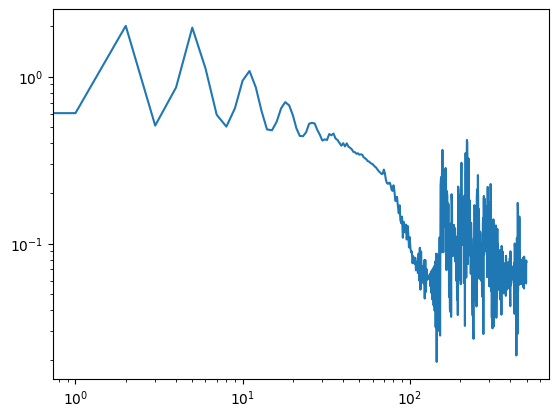

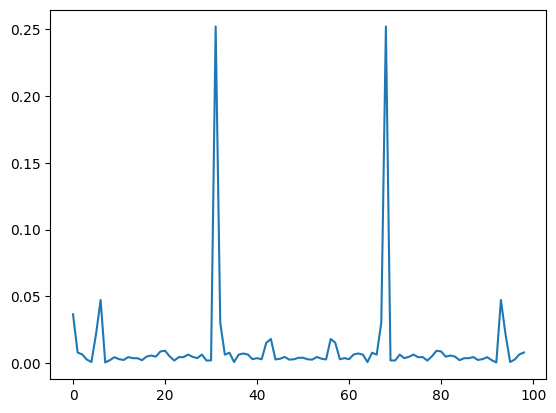

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


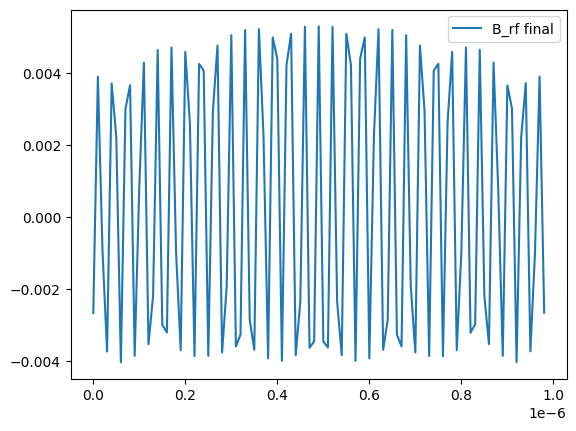

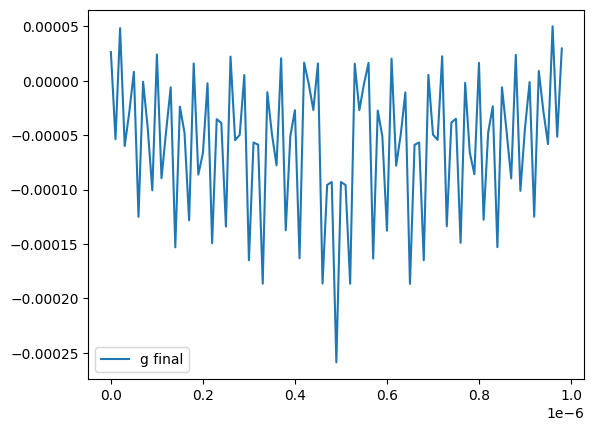

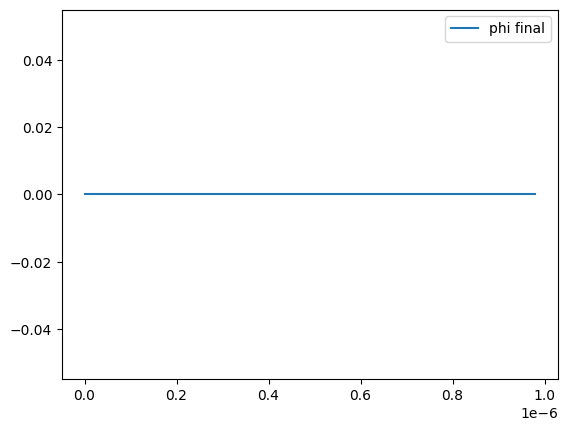

tensor([[ 0.4975-0.0031j, -0.1015+0.5177j],
        [-0.0912-0.4651j,  0.5025+0.0031j]], dtype=torch.complex128,
       grad_fn=<ViewBackward0>)


In [7]:
# Print cost fxn 
plt.loglog(range(epochs), loss_array)
plt.show()


# Show trained parameters
plt.plot(np.abs(np.fft.fft(B_rf.real.detach().numpy())))
plt.show()
plt.plot(t_units, B_rf.detach().numpy() , label = "B_rf final")
plt.legend(loc='best')
plt.show() 

plt.plot(t_units, g.detach().numpy(), label="g final")
plt.legend(loc='best')
plt.show() 

plt.plot(t_units, phi.detach().numpy(), label = "phi final")
plt.legend(loc='best')
plt.show()

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )
print(rho_out.view(2,2))
